## ⚡ Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [3]:
!nvidia-smi

Thu Feb 22 18:23:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off | 00000000:05:00.0  On |                  N/A |
| 28%   53C    P2              60W / 250W |   5376MiB / 11264MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 🧪 Install autodistill

**NOTE:** Autodistill is an ecosystem for using big, slower foundation models to train small, faster supervised models. Each Base, as well as the Target model, has its own separate repository and pip package.

In [4]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
roboflow \
supervision

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print(HOME)
!mkdir {HOME}/images
VIDEO_DIR_PATH = f"{HOME}/videos"
IMAGE_DIR_PATH = f"{HOME}/images"
FRAME_STRIDE = 10
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)
DATASET_DIR_PATH = f"{HOME}/dataset"

/workspaces/solar_eyes/sandbox
mkdir: cannot create directory ‘/workspaces/solar_eyes/sandbox/images’: File exists


**NOTE:** Notice that we put two of our videos aside so that we can use them at the end of the notebook to evaluate our model.

### Display image sample

**NOTE:** Before we start building a model with autodistill, let's make sure we have everything we need.

In [3]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpeg"])

print('image count:', len(image_paths))

image count: 151


**NOTE:** We can also plot sample of our image dataset.

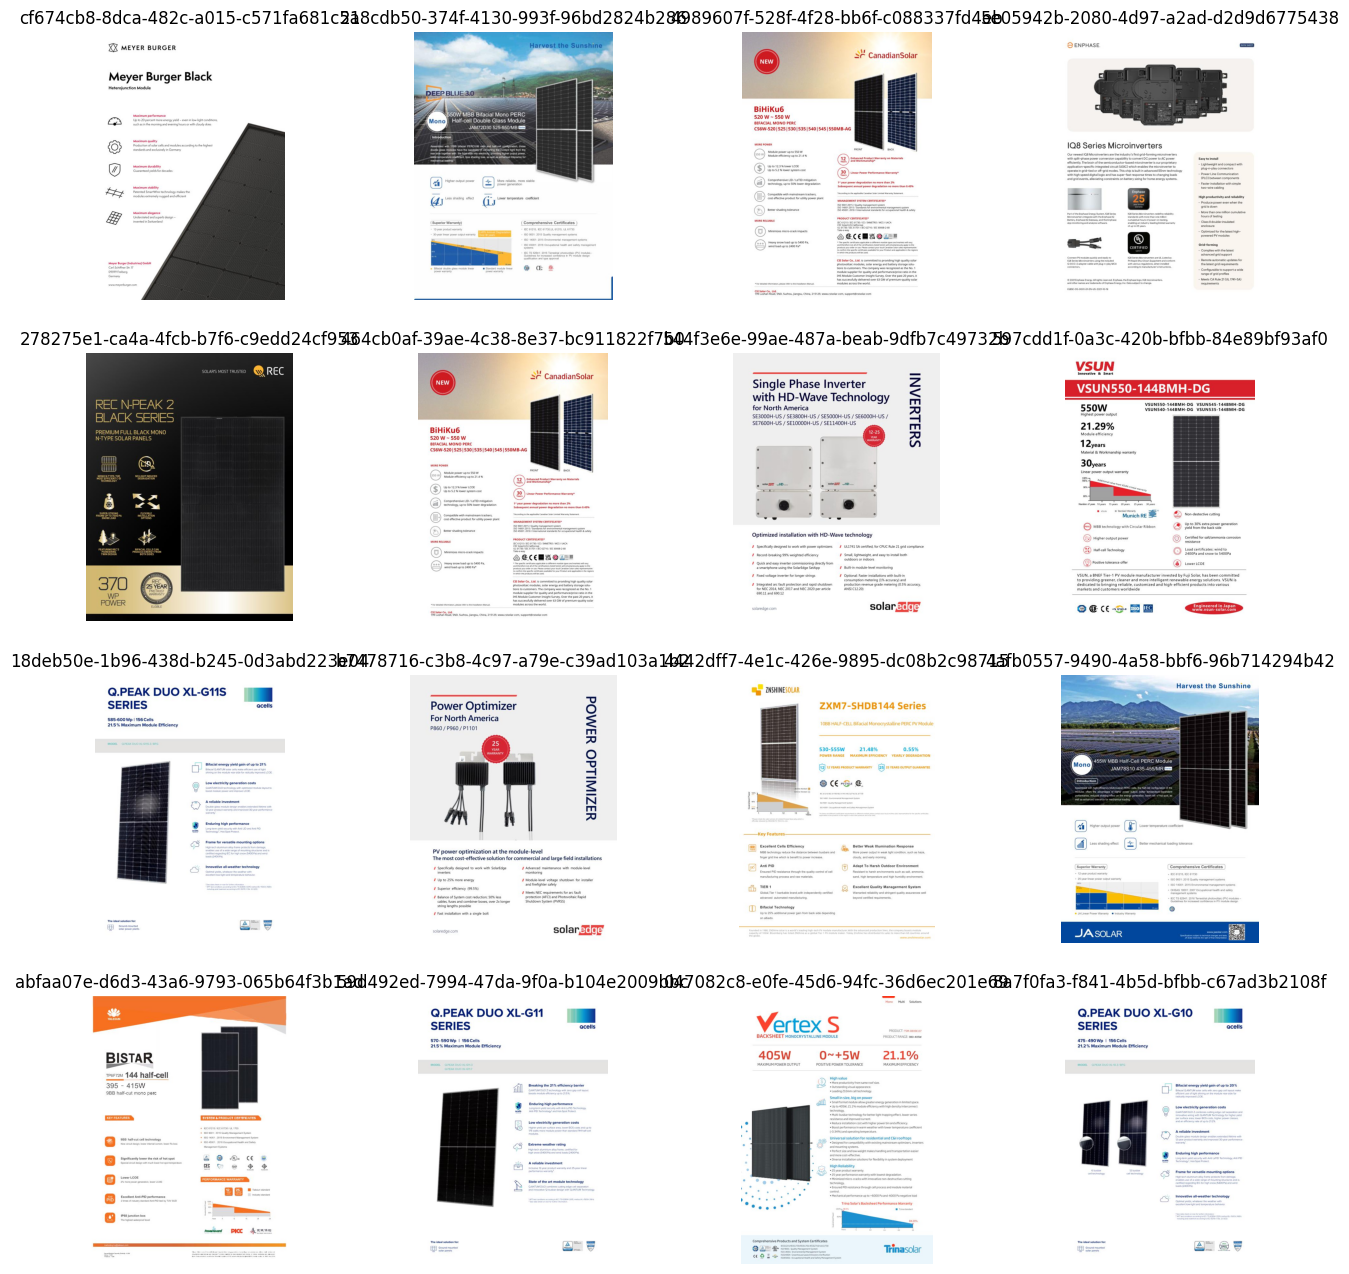

In [5]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## 🏷️ Autolabel dataset

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [2]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "solar panel": "solar panel"
})

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

**NOTE:** Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕

In [8]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)


final text_encoder_type: bert-base-uncased


In [9]:

dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpeg",
    output_folder=DATASET_DIR_PATH,
    record_confidence=True,
    human_in_the_loop=False,
    roboflow_project="sol-invictus"
    )

Labeling /workspaces/solar_eyes/sandbox/images/cf674cb8-8dca-482c-a015-c571fa681c51.jpeg:   0%|          | 0/151 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
Labeling /workspaces/solar_eyes/sandbox/images/dac84281-c973-4984-acc8-6d17be15bb26.jpeg: 100%|██████████| 151/151 [07:29<00:00,  2.97s/it]


Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-cf674cb8-8dca-482c-a015-c571fa681c51.txt
Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-2a8cdb50-374f-4130-993f-96bd2824b286.txt
Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-4989607f-528f-4f28-bb6f-c088337fd4eb.txt
Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-5e05942b-2080-4d97-a2ad-d2d9d6775438.txt
Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-278275e1-ca4a-4fcb-b7f6-c9edd24cf953.txt
Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-464cb0af-39ae-4c38-8e37-bc911822f7b0.txt
Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-544f3e6e-99ae-487a-beab-9dfb7c49732b.txt
Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-597cdd1f-0a3c-420b-bfbb-84e89bf93

### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [3]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [4]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

151

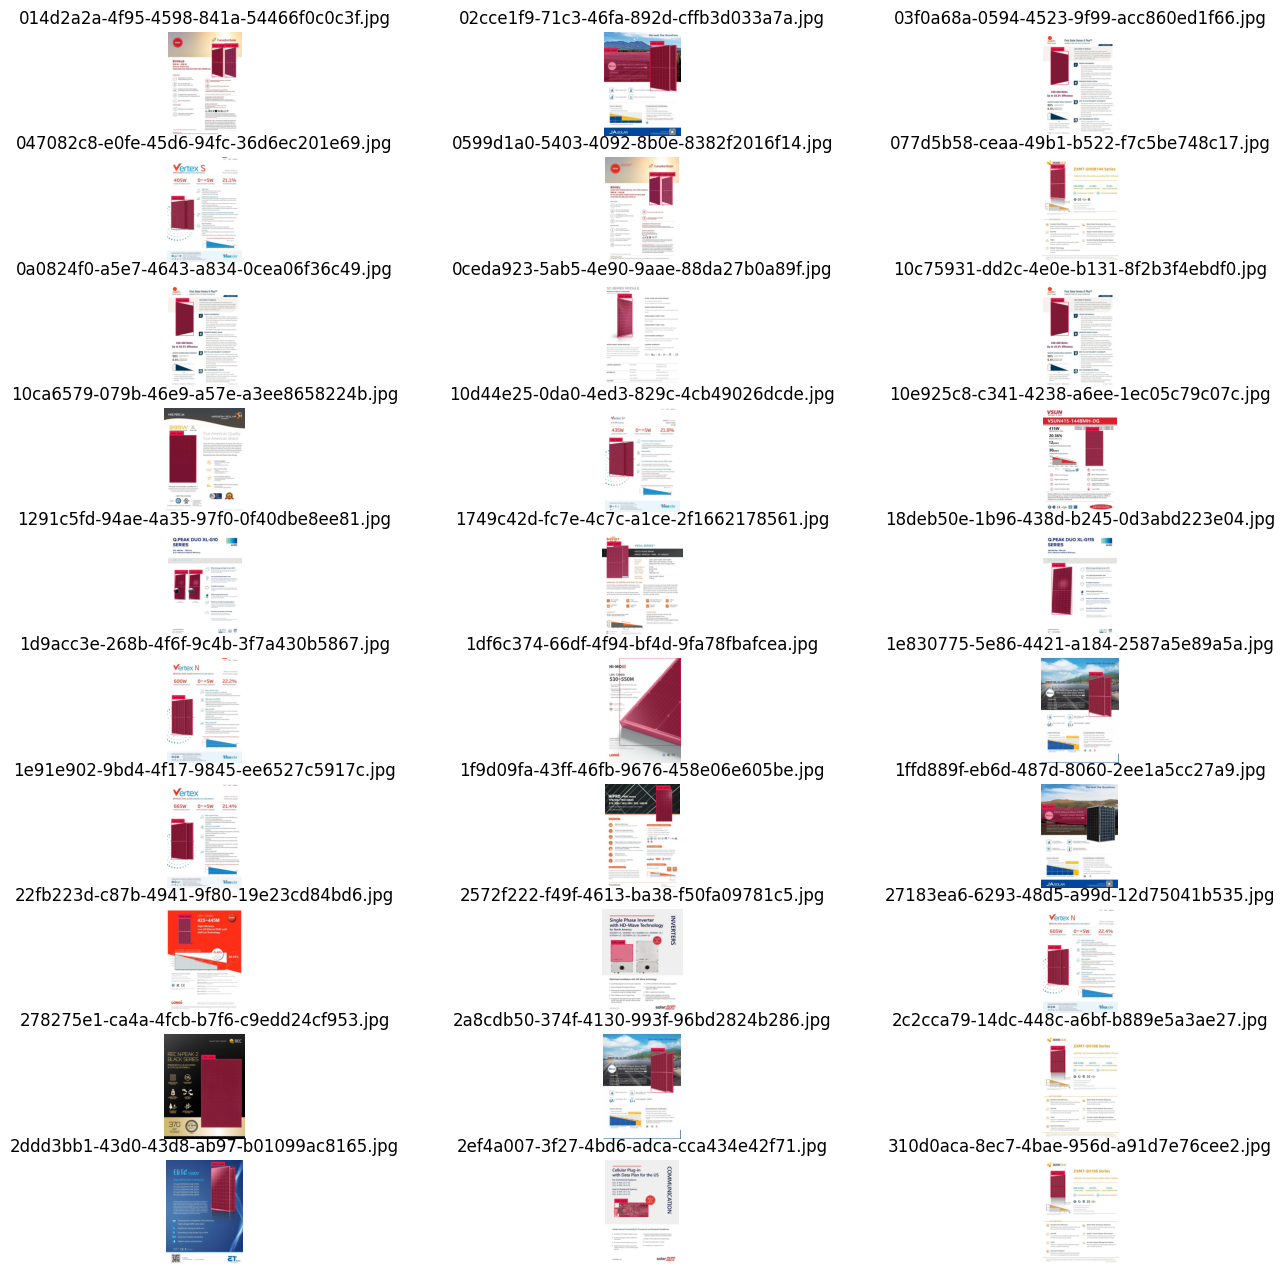

In [15]:
import supervision as sv

SAMPLE_SIZE = 30
SAMPLE_GRID_SIZE = (10, 3)
SAMPLE_PLOT_SIZE = (16, 16)

image_names = list(dataset.images.keys())
image_names.sort()
image_names = image_names[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

In [13]:
import os

# Constants (Adjust these as needed)
FOLDER_PATH = './dataset/train/labels'  # Set your folder path here
CONFIDENCE_THRESHOLD = 0.52  # Set your confidence threshold here

def process_files_with_confidence_update(folder_path, confidence_threshold):
    # Find all polygon and confidence files
    polygon_files = [f for f in os.listdir(folder_path) if f.endswith('.txt') and not f.startswith('confidence-')]
    confidence_files = [f for f in os.listdir(folder_path) if f.startswith('confidence-')]

    for poly_file in polygon_files:
        uuid = poly_file[:-4]  # Remove '.txt' extension
        conf_file = f"confidence-{uuid}.txt"

        if conf_file in confidence_files:
            # Read and process files
            with open(os.path.join(folder_path, poly_file), 'r') as pf, open(os.path.join(folder_path, conf_file), 'r') as cf:
                polygon_lines = pf.readlines()
                confidence_lines = cf.readlines()

                # Filter polygon and confidence lines based on confidence threshold
                filtered_polygons = []
                filtered_confidences = []
                for poly_line, conf_line in zip(polygon_lines, confidence_lines):
                    if float(conf_line.strip()) >= confidence_threshold:
                        filtered_polygons.append(poly_line)
                        filtered_confidences.append(conf_line)

            # Write filtered data back to the files
            with open(os.path.join(folder_path, poly_file), 'w') as pf, open(os.path.join(folder_path, conf_file), 'w') as cf:
                pf.writelines(filtered_polygons)
                cf.writelines(filtered_confidences)

    print("Processing and confidence file update complete.")

# Example usage
process_files_with_confidence_update(FOLDER_PATH, CONFIDENCE_THRESHOLD)

# Note: Uncomment the above line and adjust the FOLDER_PATH and CONFIDENCE_THRESHOLD to use the script.


Processing and confidence file update complete.


In [16]:
import torch
torch.cuda.is_available()

True

## 🔥 Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [18]:
%cd {HOME}

from ultralytics import YOLO

target_model = YOLO("yolov8s.pt")
target_model.train(data=DATA_YAML_PATH, epochs=50, device="0,1,2", batch=18)

/workspaces/solar_eyes/sandbox
Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
                                                            CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
                                                            CUDA:2 (NVIDIA TITAN X (Pascal), 12190MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/workspaces/solar_eyes/sandbox/dataset/data.yaml, epochs=50, time=None, patience=100, batch=18, imgsz=640, save=True, save_period=-1, cache=False, device=0,1,2, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=Fal

using dhist requires you to install the `pickleshare` library.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
[W Utils.hpp:164] Warning: Environment variable NCCL_BLOCKING_WAIT is deprecated; use TORCH_NCCL_BLOCKING_WAIT instead (function getCvarBool)
[W Utils.hpp:164] Warning: Environment variable NCCL_BLOCKING_WAIT is deprecated; use TORCH_NCCL_BLOCKING_WAIT instead (function getCvarBool)
[W Utils.hpp:164] Warning: Environment variable NCCL_BLOCKING_WAIT is deprecated; use TORCH_NCCL_BLOCKING_WAIT instead (function getCvarBool)


Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
                                                            CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
                                                            CUDA:2 (NVIDIA TITAN X (Pascal), 12190MiB)
Overriding model.yaml nc=80 with nc=1
Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


[rank1]:[W Utils.hpp:106] Warning: Environment variable NCCL_BLOCKING_WAIT is deprecated; use TORCH_NCCL_BLOCKING_WAIT instead (function getCvarString)
[rank2]:[W Utils.hpp:106] Warning: Environment variable NCCL_BLOCKING_WAIT is deprecated; use TORCH_NCCL_BLOCKING_WAIT instead (function getCvarString)
[rank0]:[W Utils.hpp:106] Warning: Environment variable NCCL_BLOCKING_WAIT is deprecated; use TORCH_NCCL_BLOCKING_WAIT instead (function getCvarString)
train: Scanning /workspaces/solar_eyes/sandbox/dataset/train/labels... 151 images, 5 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<00:00, 1739.16it/s]


train: New cache created: /workspaces/solar_eyes/sandbox/dataset/train/labels.cache


val: Scanning /workspaces/solar_eyes/sandbox/dataset/valid/labels... 126 images, 0 backgrounds, 0 corrupt: 100%|██████████| 126/126 [00:00<00:00, 689.63it/s]


val: New cache created: /workspaces/solar_eyes/sandbox/dataset/valid/labels.cache
Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005625000000000001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 18 dataloader workers
Logging results to runs/detect/train6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.77G     0.9772      4.574      1.169         12        640: 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  8.06it/s]


                   all        126        293      0.311      0.133      0.123     0.0865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.85G     0.4234      1.929     0.8999          4        640: 100%|██████████| 9/9 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.72it/s]


                   all        126        293       0.94      0.484      0.521      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.85G     0.4207      1.266     0.9068          6        640: 100%|██████████| 9/9 [00:01<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  8.93it/s]


                   all        126        293      0.917       0.49      0.524      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.86G     0.4448     0.9826     0.9461          3        640: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.42it/s]


                   all        126        293      0.945      0.471      0.507      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.86G     0.4484     0.8023     0.8867          6        640: 100%|██████████| 9/9 [00:01<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.65it/s]


                   all        126        293       0.94      0.488      0.511      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.86G     0.3964     0.6716     0.8434          3        640: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.06it/s]


                   all        126        293      0.922      0.498      0.542      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.86G     0.4468     0.6489     0.8441          3        640: 100%|██████████| 9/9 [00:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.38it/s]


                   all        126        293      0.963      0.488      0.559      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.86G     0.4112     0.5771     0.8259          6        640: 100%|██████████| 9/9 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.36it/s]


                   all        126        293      0.894      0.509      0.554      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.86G     0.5018      0.698     0.8688          3        640: 100%|██████████| 9/9 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.22it/s]


                   all        126        293      0.955      0.505      0.571      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.87G     0.4377     0.5591      0.867          8        640: 100%|██████████| 9/9 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.48it/s]


                   all        126        293      0.791      0.466      0.531      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.87G     0.4612     0.6421     0.8791          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.40it/s]


                   all        126        293      0.907      0.505       0.54      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.87G     0.4633     0.5544     0.9036          7        640: 100%|██████████| 9/9 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.32it/s]


                   all        126        293      0.632      0.462      0.391      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.87G     0.5007     0.6231       0.93          5        640: 100%|██████████| 9/9 [00:01<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.54it/s]


                   all        126        293      0.862      0.489        0.5      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.85G     0.5054     0.6174     0.8783          6        640: 100%|██████████| 9/9 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.33it/s]


                   all        126        293      0.901      0.502      0.517      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.86G     0.4336     0.4931     0.8912         15        640: 100%|██████████| 9/9 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.48it/s]


                   all        126        293      0.894       0.49      0.539      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.87G     0.4474     0.4768     0.8758         14        640: 100%|██████████| 9/9 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.15it/s]


                   all        126        293      0.857       0.49      0.499       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.87G     0.4565     0.5273     0.8736          7        640: 100%|██████████| 9/9 [00:01<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.22it/s]


                   all        126        293      0.915      0.464      0.491       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.86G     0.4633     0.5296     0.9239          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.89it/s]


                   all        126        293      0.903      0.491      0.521       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.86G        0.4     0.4192      0.832          7        640: 100%|██████████| 9/9 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.74it/s]


                   all        126        293      0.972      0.505      0.542      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.86G     0.5054     0.5596      0.921          3        640: 100%|██████████| 9/9 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.54it/s]


                   all        126        293      0.978      0.515      0.555      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.87G     0.3979     0.3979     0.8529          9        640: 100%|██████████| 9/9 [00:01<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.36it/s]


                   all        126        293      0.992      0.515      0.544      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.85G     0.3676     0.3806     0.8784          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.43it/s]


                   all        126        293      0.975      0.526      0.582      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.86G     0.3762     0.4343     0.8363          7        640: 100%|██████████| 9/9 [00:01<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.32it/s]


                   all        126        293          1      0.498      0.548      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.86G     0.4732     0.4757     0.9125         11        640: 100%|██████████| 9/9 [00:01<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.30it/s]


                   all        126        293      0.968      0.509      0.539      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.87G     0.3769     0.3819      0.857          6        640: 100%|██████████| 9/9 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.71it/s]


                   all        126        293      0.989      0.498      0.527      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.86G     0.3757      0.402     0.8658         11        640: 100%|██████████| 9/9 [00:01<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.54it/s]


                   all        126        293      0.993      0.502      0.541      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.86G     0.3737      0.354     0.8618         10        640: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.90it/s]


                   all        126        293      0.947      0.502      0.532      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.87G     0.4259     0.3903     0.8534          4        640: 100%|██████████| 9/9 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.60it/s]


                   all        126        293      0.989      0.495      0.525      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.87G       0.43     0.4601     0.9442          9        640: 100%|██████████| 9/9 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.48it/s]


                   all        126        293      0.973        0.5      0.541       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.85G     0.4082     0.3682     0.8655          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.94it/s]


                   all        126        293      0.968      0.512      0.566      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.86G     0.3839     0.3645     0.9035          5        640: 100%|██████████| 9/9 [00:01<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.01it/s]


                   all        126        293      0.946      0.512       0.57      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.86G     0.3836     0.3542     0.8727         11        640: 100%|██████████| 9/9 [00:01<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.19it/s]


                   all        126        293      0.937      0.509      0.555      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.87G     0.3675     0.3453     0.8488          8        640: 100%|██████████| 9/9 [00:01<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.60it/s]


                   all        126        293      0.987      0.505      0.553      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.86G     0.3395     0.3686     0.8678         10        640: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.31it/s]


                   all        126        293       0.98      0.511      0.558      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.86G     0.3144     0.2884     0.8438          8        640: 100%|██████████| 9/9 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.63it/s]


                   all        126        293      0.962      0.509      0.559      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.87G     0.3211     0.3046      0.848         10        640: 100%|██████████| 9/9 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.93it/s]


                   all        126        293      0.966      0.509      0.561      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.86G     0.3224     0.3151     0.8361          8        640: 100%|██████████| 9/9 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.41it/s]


                   all        126        293      0.993      0.507      0.561      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.85G     0.3086     0.3056      0.828          3        640: 100%|██████████| 9/9 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.26it/s]


                   all        126        293      0.999      0.505      0.567      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.87G     0.3316     0.3027     0.8578          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.99it/s]


                   all        126        293      0.985      0.505      0.573      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.87G     0.3065     0.3146     0.8323          9        640: 100%|██████████| 9/9 [00:01<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.75it/s]


                   all        126        293          1      0.507      0.577      0.553
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.87G     0.2466     0.2532     0.8026          3        640: 100%|██████████| 9/9 [00:02<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.70it/s]


                   all        126        293          1      0.502      0.563      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.85G     0.2327     0.2461      0.775          3        640: 100%|██████████| 9/9 [00:01<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.46it/s]


                   all        126        293          1      0.495      0.553      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.86G     0.2224     0.2384     0.8111          3        640: 100%|██████████| 9/9 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.98it/s]


                   all        126        293          1      0.495      0.551       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.86G     0.2223     0.2505     0.7969          3        640: 100%|██████████| 9/9 [00:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.44it/s]


                   all        126        293          1      0.493      0.551      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.86G     0.2336     0.2583     0.8257          5        640: 100%|██████████| 9/9 [00:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.12it/s]


                   all        126        293          1      0.491      0.551      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.85G     0.2125     0.2285     0.7867          3        640: 100%|██████████| 9/9 [00:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.68it/s]


                   all        126        293      0.999      0.495      0.551      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.87G     0.1699     0.2233     0.7549          3        640: 100%|██████████| 9/9 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  9.97it/s]


                   all        126        293      0.986      0.492      0.548      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.87G     0.2036     0.2327     0.8187          5        640: 100%|██████████| 9/9 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.03it/s]


                   all        126        293          1      0.494      0.554      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.87G     0.1791     0.2222     0.8086          3        640: 100%|██████████| 9/9 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.45it/s]


                   all        126        293      0.998      0.495      0.561       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.85G      0.176     0.2027     0.7326          3        640: 100%|██████████| 9/9 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.17it/s]


                   all        126        293       0.99      0.495      0.564      0.554

50 epochs completed in 0.049 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 22.5MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
                                                            CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
                                                            CUDA:2 (NVIDIA TITAN X (Pascal), 12190MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.98it/s]


                   all        126        293       0.99      0.495      0.564      0.554
Speed: 0.8ms preprocess, 6.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train6


In [5]:
%cd {HOME}

from ultralytics import YOLO

target_model_seg = YOLO("yolov8s-seg.pt")
target_model_seg.train(data=DATA_YAML_PATH, epochs=200, device="0,1,2", batch=18)

using dhist requires you to install the `pickleshare` library.


/workspaces/solar_eyes/sandbox


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


100%|██████████| 22.8M/22.8M [00:00<00:00, 108MB/s] 


Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
                                                            CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
                                                            CUDA:2 (NVIDIA TITAN X (Pascal), 12190MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/workspaces/solar_eyes/sandbox/dataset/data.yaml, epochs=200, time=None, patience=100, batch=18, imgsz=640, save=True, save_period=-1, cache=False, device=0,1,2, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=Non

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************


Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
                                                            CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
                                                            CUDA:2 (NVIDIA TITAN X (Pascal), 12190MiB)
Overriding model.yaml nc=80 with nc=1


[W Utils.hpp:164] Warning: Environment variable NCCL_BLOCKING_WAIT is deprecated; use TORCH_NCCL_BLOCKING_WAIT instead (function getCvarBool)
[W Utils.hpp:164] Warning: Environment variable NCCL_BLOCKING_WAIT is deprecated; use TORCH_NCCL_BLOCKING_WAIT instead (function getCvarBool)
[W Utils.hpp:164] Warning: Environment variable NCCL_BLOCKING_WAIT is deprecated; use TORCH_NCCL_BLOCKING_WAIT instead (function getCvarBool)


Transferred 411/417 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


[rank1]:[W Utils.hpp:106] Warning: Environment variable NCCL_BLOCKING_WAIT is deprecated; use TORCH_NCCL_BLOCKING_WAIT instead (function getCvarString)
[rank2]:[W Utils.hpp:106] Warning: Environment variable NCCL_BLOCKING_WAIT is deprecated; use TORCH_NCCL_BLOCKING_WAIT instead (function getCvarString)
[rank0]:[W Utils.hpp:106] Warning: Environment variable NCCL_BLOCKING_WAIT is deprecated; use TORCH_NCCL_BLOCKING_WAIT instead (function getCvarString)
train: Scanning /workspaces/solar_eyes/sandbox/dataset/train/labels.cache... 151 images, 5 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]
val: Scanning /workspaces/solar_eyes/sandbox/dataset/valid/labels.cache... 126 images, 0 backgrounds, 0 corrupt: 100%|██████████| 126/126 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005625000000000001), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 18 dataloader workers
Logging results to runs/segment/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.28G      1.002       2.45      4.507       1.23         12        640: 100%|██████████| 9/9 [00:03<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.01it/s]


                   all        126        293     0.0507      0.109     0.0207     0.0124     0.0499      0.109     0.0176     0.0105

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.48G     0.5132     0.7467      2.094     0.9444          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.45it/s]


                   all        126        293      0.859      0.597      0.623      0.568      0.854      0.594      0.613      0.351

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.41G     0.4346     0.3847      1.426       0.88          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.88it/s]


                   all        126        293      0.858      0.519       0.53      0.505      0.846      0.512      0.521      0.309

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.42G     0.4948     0.4645      1.018     0.9476          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.26it/s]


                   all        126        293      0.903      0.495      0.533      0.474      0.877      0.481      0.506      0.309

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/200       2.4G     0.5006     0.3389     0.7712     0.8807          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.42it/s]


                   all        126        293      0.956      0.512      0.599      0.501      0.955      0.509      0.571      0.343

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.43G     0.4544     0.3196     0.7499     0.8615          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.69it/s]


                   all        126        293      0.902      0.498      0.518      0.455      0.895      0.495      0.515      0.298

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.43G      0.497      0.519     0.7302     0.8659          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.66it/s]


                   all        126        293        0.9      0.489      0.536      0.465      0.941      0.474      0.508      0.287

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.57G     0.5049     0.4848     0.8683     0.8618          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.37it/s]


                   all        126        293      0.862      0.454      0.495      0.428      0.836       0.44      0.479      0.278

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.44G     0.5298     0.4782     0.7868      0.893          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.25it/s]


                   all        126        293      0.641      0.454      0.427      0.343      0.473      0.334      0.263      0.123

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.42G     0.5148     0.5731      0.675     0.9068          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.45it/s]


                   all        126        293       0.74      0.446      0.439      0.331      0.728      0.439      0.423      0.233

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.42G     0.5138     0.4538     0.6867     0.9133          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.54it/s]


                   all        126        293      0.516      0.283      0.233      0.142      0.516      0.283       0.22     0.0819

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.58G     0.5186      0.344     0.6247     0.9259          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.55it/s]


                   all        126        293      0.362      0.451      0.395       0.29      0.357      0.444      0.389      0.171

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.41G     0.5353     0.4152      0.673     0.8986          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.55it/s]


                   all        126        293       0.74      0.311      0.356      0.284      0.715        0.3      0.346      0.156

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.58G     0.5529     0.5412     0.5589     0.8729          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.57it/s]


                   all        126        293      0.766      0.447      0.475      0.412      0.784      0.437      0.465      0.249

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.47G     0.5188      0.496     0.5638     0.9063         15        640: 100%|██████████| 9/9 [00:02<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.54it/s]


                   all        126        293      0.764      0.433      0.433      0.357      0.756       0.43      0.421       0.22

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.61G     0.5261     0.3834     0.5747     0.8897         14        640: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.35it/s]


                   all        126        293        0.8      0.488      0.504      0.414        0.8      0.488      0.491      0.262

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.41G     0.5466     0.3847     0.5786     0.8933          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.35it/s]


                   all        126        293      0.957      0.498      0.534      0.458       0.95      0.495      0.526       0.28

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.42G     0.5221     0.3994     0.6154     0.9406          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.59it/s]


                   all        126        293      0.893      0.464      0.508      0.435      0.835      0.416      0.452      0.212

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.58G     0.4401     0.2544     0.5085     0.8474          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.65it/s]


                   all        126        293      0.874      0.457      0.496      0.395      0.819      0.427       0.45      0.248

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.44G     0.5903     0.4539     0.6535     0.9373          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.59it/s]


                   all        126        293      0.918      0.481      0.521      0.455      0.856      0.491       0.52       0.28

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.43G     0.4544     0.3613     0.5079     0.8617          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.62it/s]


                   all        126        293      0.928      0.484      0.581      0.478      0.928      0.485      0.562      0.322

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/200       2.4G     0.4714     0.2723     0.4927     0.9204          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.54it/s]


                   all        126        293      0.954      0.494      0.604      0.525      0.946      0.488      0.589      0.344

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.41G     0.4703     0.2302     0.4886      0.849          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.65it/s]


                   all        126        293      0.802      0.491      0.507       0.44      0.808      0.495      0.503       0.32

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.59G     0.5923      0.327      0.537     0.9319         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.44it/s]


                   all        126        293      0.749      0.505      0.468      0.392      0.745        0.5      0.459      0.268

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.41G     0.4988     0.2448     0.5313     0.9057          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.63it/s]


                   all        126        293      0.986      0.494      0.534      0.471      0.966      0.484      0.512      0.334

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.57G     0.4898     0.3282     0.4878     0.9017         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.39it/s]


                   all        126        293      0.967      0.497      0.541      0.481       0.96      0.494      0.523      0.299

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.59G     0.4715     0.2593     0.4978     0.8905         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.66it/s]


                   all        126        293      0.849      0.519      0.537      0.486      0.844      0.516      0.525      0.321

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.41G     0.5553     0.3594     0.5226      0.904          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.62it/s]


                   all        126        293      0.899      0.488      0.519      0.477      0.899      0.488      0.512      0.355

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.42G     0.5627       0.24     0.6679      1.007          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.53it/s]


                   all        126        293      0.887      0.509      0.535       0.49      0.886      0.512      0.529       0.31

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.39G      0.499     0.3266     0.4717     0.8976          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.53it/s]


                   all        126        293      0.915      0.529      0.546      0.485      0.911      0.526      0.536      0.321

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/200       2.4G      0.479     0.2408     0.4941     0.9164          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.58it/s]


                   all        126        293      0.952      0.509      0.538      0.473      0.945      0.505      0.523      0.328

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.59G     0.4663     0.2695     0.4527     0.9023         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.43it/s]


                   all        126        293      0.942      0.529      0.565      0.517      0.917      0.515      0.547      0.347

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.42G     0.4959     0.2852     0.4701     0.8951          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.65it/s]


                   all        126        293      0.952      0.515      0.557      0.516      0.983      0.502      0.541      0.334

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.39G       0.43     0.3765     0.4206     0.8679         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.45it/s]


                   all        126        293      0.961        0.5       0.57      0.534      0.961        0.5      0.557      0.346

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.41G      0.378      0.231      0.363     0.8315          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.71it/s]


                   all        126        293      0.982      0.495      0.549      0.518      0.982      0.495      0.539       0.34

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/200       2.4G     0.4241     0.2267     0.4246     0.8912         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.58it/s]


                   all        126        293      0.973      0.491       0.55      0.514      0.973      0.491      0.533      0.336

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.59G      0.432     0.2682     0.3828     0.8631          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.72it/s]


                   all        126        293      0.986      0.487      0.531      0.481      0.986      0.487       0.52      0.322

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.56G     0.4146     0.4328     0.3901     0.8711          3        640: 100%|██████████| 9/9 [00:02<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.73it/s]


                   all        126        293          1      0.481      0.533       0.49          1      0.481      0.518      0.348

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.41G     0.4358     0.3088     0.3892     0.8862          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.60it/s]


                   all        126        293          1      0.477       0.54      0.505          1      0.477      0.526      0.373

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.43G     0.4308     0.3053     0.4716     0.8972          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.63it/s]


                   all        126        293      0.955      0.495      0.542      0.505      0.955      0.495      0.528      0.386

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.43G     0.4656     0.2841     0.4653     0.8852          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.80it/s]


                   all        126        293      0.978      0.502      0.532        0.5      0.971      0.498      0.527      0.367

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.58G     0.5051     0.3268     0.4357     0.9032          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.79it/s]


                   all        126        293      0.962      0.505      0.528      0.502      0.955      0.502      0.524       0.36

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.43G     0.4325     0.2656     0.3926     0.8846          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.53it/s]


                   all        126        293      0.952      0.505      0.539      0.497      0.952      0.505      0.534      0.364

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.59G     0.4184     0.3089     0.3869       0.87         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.46it/s]


                   all        126        293      0.965      0.509      0.542      0.507      0.965      0.509      0.537      0.378

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.43G     0.4313     0.3111     0.4549     0.8845          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.52it/s]


                   all        126        293      0.972      0.505      0.549      0.515      0.972      0.505      0.543       0.39

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.56G     0.4138     0.2923     0.3585     0.8839         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.64it/s]


                   all        126        293      0.977      0.505      0.533       0.51      0.977      0.505      0.538      0.372

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.41G     0.4248     0.3056     0.3815     0.8883          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.53it/s]


                   all        126        293      0.993      0.502       0.53      0.506      0.993      0.501      0.533       0.38

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.45G       0.42     0.3367     0.3685     0.8736          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.64it/s]


                   all        126        293      0.949      0.511      0.558      0.529      0.967        0.5      0.557      0.384

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.41G     0.5133      0.341     0.4298     0.9746          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.67it/s]


                   all        126        293      0.972      0.488       0.52      0.493      0.972      0.488      0.522      0.352

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.41G     0.4678     0.3233     0.4205     0.9107          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.64it/s]


                   all        126        293      0.888      0.488      0.508      0.476      0.882      0.485      0.515      0.369

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/200       2.4G     0.3778     0.2953     0.3509     0.8754         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.62it/s]


                   all        126        293      0.926      0.491       0.55      0.515       0.92      0.488      0.545      0.396

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.41G     0.4282      0.283     0.4852     0.9189          2        640: 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.62it/s]


                   all        126        293      0.979      0.491      0.538      0.509      0.972      0.488      0.535      0.372

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/200       2.4G     0.4045     0.2253     0.3819     0.8554          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.64it/s]


                   all        126        293      0.965      0.491      0.529      0.487      0.957      0.488      0.524      0.339

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.46G     0.3747      0.318      0.348     0.8685         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.74it/s]


                   all        126        293       0.95      0.382      0.475      0.444       0.95      0.382      0.473      0.312

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.41G     0.3984     0.3445      0.396     0.8771          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.52it/s]


                   all        126        293      0.897      0.399      0.483      0.446      0.897      0.399      0.474      0.292

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/200       2.4G     0.4024     0.2462     0.3555     0.9102          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.67it/s]


                   all        126        293      0.813        0.4      0.444      0.419      0.813        0.4      0.435      0.242

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.59G     0.3851     0.2278     0.3307      0.847          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.49it/s]


                   all        126        293      0.923      0.386      0.454      0.421      0.923      0.386       0.45      0.264

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.39G     0.4002     0.2918     0.3878     0.8691          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.62it/s]


                   all        126        293      0.948      0.468       0.51      0.479       0.95      0.464      0.504      0.301

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/200       2.4G     0.4355     0.2848     0.3741     0.8894         12        640: 100%|██████████| 9/9 [00:02<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.68it/s]


                   all        126        293       0.94      0.498      0.541      0.521      0.934      0.495      0.531      0.316

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.59G     0.4197     0.2799     0.3972     0.8783          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.70it/s]


                   all        126        293      0.973      0.502      0.552      0.531      0.973      0.502      0.543      0.344

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.57G     0.3537     0.2349     0.3358     0.8428         13        640: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.81it/s]


                   all        126        293      0.979       0.48      0.543      0.515      0.948      0.494      0.547       0.34

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.43G     0.3832     0.2605     0.3549     0.8326         13        640: 100%|██████████| 9/9 [00:02<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.54it/s]


                   all        126        293      0.928      0.485      0.553      0.517      0.928      0.485      0.554      0.352

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.56G     0.3982      0.279     0.3942     0.8824          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.70it/s]


                   all        126        293      0.919      0.506      0.567      0.533      0.921      0.505      0.564      0.389

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.57G     0.3758     0.2995     0.4503     0.8524         12        640: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.46it/s]


                   all        126        293      0.992      0.495      0.559      0.538      0.992      0.495       0.55      0.361

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.57G     0.4429     0.3715     0.3915     0.8995          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.67it/s]


                   all        126        293       0.98      0.501      0.573      0.545      0.978      0.498       0.58      0.388

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.43G     0.3499     0.2483     0.3504     0.8602          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.77it/s]


                   all        126        293      0.989      0.488       0.58      0.546      0.981      0.491       0.58      0.409

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/200       2.4G     0.4098      0.342       0.35     0.8861         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.50it/s]


                   all        126        293      0.994      0.478      0.554      0.528      0.994      0.478      0.546      0.396

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/200       2.4G     0.3795     0.2567     0.3334     0.8703          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.63it/s]


                   all        126        293      0.952      0.502      0.552      0.529      0.952      0.502      0.551      0.404

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.41G     0.3922     0.3261     0.3562     0.8815          2        640: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.85it/s]


                   all        126        293      0.987      0.512      0.566      0.543      0.987      0.512      0.565      0.421

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.45G     0.3703     0.2322     0.3064     0.8767          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.58it/s]


                   all        126        293      0.993      0.505      0.536      0.514      0.987      0.502      0.535      0.387

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/200       2.4G     0.3881     0.2048     0.3199     0.8519          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.57it/s]


                   all        126        293      0.991      0.509       0.53      0.518      0.984      0.505      0.524       0.38

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.42G     0.3797     0.2619     0.3328     0.8488          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.56it/s]


                   all        126        293      0.992      0.505      0.525      0.498      0.992      0.505      0.521      0.359

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.42G     0.4354     0.2488      0.404      0.895          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.57it/s]


                   all        126        293      0.992      0.502      0.532      0.506      0.992      0.502      0.531      0.348

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/200       2.4G     0.4107     0.2143     0.3543     0.8342          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.50it/s]


                   all        126        293      0.992      0.498      0.542      0.525      0.992      0.498      0.538      0.347

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/200       2.4G     0.4499     0.2341     0.3881     0.8776         15        640: 100%|██████████| 9/9 [00:02<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.72it/s]


                   all        126        293       0.98      0.498       0.55       0.53       0.98      0.498      0.543      0.357

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.59G     0.3946     0.2728     0.3376     0.8395          2        640: 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.41it/s]


                   all        126        293      0.986      0.498      0.561      0.539      0.986      0.498      0.553      0.359

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/200       2.4G      0.401     0.2309     0.3586     0.8799         13        640: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.63it/s]


                   all        126        293      0.999      0.498      0.566      0.535      0.992      0.495      0.552      0.366

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.39G     0.3326     0.2166     0.3156     0.8361          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.74it/s]


                   all        126        293      0.997      0.495      0.566      0.541      0.997      0.495      0.552      0.353

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.43G     0.3768     0.2768     0.3171     0.8468          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.70it/s]


                   all        126        293      0.997      0.491      0.566      0.542      0.997      0.491      0.558      0.367

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.43G     0.3911     0.2742     0.3693     0.8887          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.58it/s]


                   all        126        293      0.994      0.491      0.577      0.561      0.994      0.491      0.571      0.375

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.43G     0.4301      0.293     0.3812     0.8447          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.63it/s]


                   all        126        293          1      0.491      0.599      0.558          1      0.491      0.572      0.364

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.42G     0.3345     0.2169     0.3131      0.843          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.76it/s]


                   all        126        293      0.992      0.495      0.592      0.551      0.992      0.495      0.552      0.353

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/200       2.4G     0.3763     0.3013      0.364     0.8872          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.70it/s]


                   all        126        293       0.98      0.497      0.587      0.556       0.98      0.497      0.559      0.359

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/200       2.4G     0.3838     0.2677     0.3269     0.8742         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.61it/s]


                   all        126        293      0.993      0.491      0.579       0.56      0.993      0.491      0.559      0.366

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.44G     0.3374      0.222     0.3074      0.832          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.84it/s]


                   all        126        293      0.999      0.491      0.559      0.544      0.999      0.491       0.55       0.36

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.44G     0.3481       0.31     0.3017     0.8509         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.59it/s]


                   all        126        293      0.992      0.491      0.574      0.558      0.992      0.491      0.571      0.379

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.43G     0.3903     0.2372     0.3224     0.8792          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.72it/s]


                   all        126        293      0.956      0.502      0.593      0.576      0.956      0.502      0.589      0.401

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/200       2.4G     0.3612     0.3856     0.3235     0.8837          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.54it/s]


                   all        126        293      0.967      0.498      0.597      0.576      0.967      0.498      0.597      0.417

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.56G     0.3933     0.3109     0.4025     0.8754         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.56it/s]


                   all        126        293      0.986      0.498      0.606      0.593      0.986      0.498      0.606      0.423

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.58G      0.318     0.1972     0.3239     0.8418          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.61it/s]


                   all        126        293      0.999      0.495      0.583      0.571      0.999      0.495      0.581      0.414

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.42G     0.3113     0.2376     0.3067     0.8711          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.67it/s]


                   all        126        293          1      0.495      0.614        0.6          1      0.495      0.606       0.45

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.58G     0.3538     0.2731       0.32     0.8328         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.65it/s]


                   all        126        293      0.999      0.491      0.638      0.627      0.999      0.491      0.634      0.476

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.45G     0.3446     0.2361     0.2978     0.8397          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.50it/s]


                   all        126        293      0.999      0.491      0.653      0.642      0.999      0.491      0.651      0.468

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/200      2.39G     0.3277     0.2642     0.3022     0.8406          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.56it/s]


                   all        126        293      0.999      0.491      0.658      0.639      0.999      0.491      0.646      0.462

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/200      2.58G     0.3619     0.2388     0.2842     0.8653         12        640: 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.52it/s]


                   all        126        293      0.999      0.491      0.667      0.647      0.999      0.491      0.667      0.477

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.58G     0.3593     0.2415     0.2836     0.8342         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.50it/s]


                   all        126        293          1      0.495      0.661      0.638          1      0.495      0.654      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/200      2.41G      0.334     0.1698     0.2685     0.8337          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.76it/s]


                   all        126        293      0.986      0.497      0.642       0.62      0.986      0.496      0.633       0.44

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.58G     0.3193     0.3539     0.2698     0.8221          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.80it/s]


                   all        126        293      0.999      0.488      0.611      0.591      0.999      0.488      0.599       0.41

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/200       2.4G     0.3327     0.2159     0.2681     0.8362          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.69it/s]


                   all        126        293      0.999      0.488      0.614      0.592      0.999      0.488      0.602      0.425

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.41G     0.3939     0.2355       0.32     0.8827          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.60it/s]


                   all        126        293      0.999      0.491      0.628       0.61      0.999      0.491      0.626      0.435

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.41G     0.2774     0.1458     0.2549     0.8398          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.73it/s]


                   all        126        293      0.998      0.491      0.637      0.616      0.998      0.491       0.62      0.454

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.39G     0.3148     0.2438     0.2815      0.852         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.69it/s]


                   all        126        293      0.977      0.495      0.619        0.6      0.977      0.495      0.617      0.417

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.41G     0.3335     0.2083     0.2818     0.8713          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.51it/s]


                   all        126        293      0.999      0.491      0.639      0.629      0.999      0.491      0.631      0.434

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.41G     0.3286      0.212      0.277     0.8672          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.66it/s]


                   all        126        293      0.986      0.495      0.658      0.646      0.986      0.495      0.653      0.455

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.43G     0.3268     0.1865     0.2677     0.8735          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.61it/s]


                   all        126        293      0.986      0.495      0.669      0.645      0.986      0.495      0.652      0.477

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.42G     0.2952     0.2035     0.2584     0.8616          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.71it/s]


                   all        126        293       0.98      0.498      0.662       0.64       0.98      0.498      0.648      0.454

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.42G     0.3245     0.1772     0.2851     0.8369         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.69it/s]


                   all        126        293       0.98        0.5      0.665      0.649      0.993      0.495      0.656      0.459

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/200       2.4G     0.3073      0.191     0.2566     0.8712          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.63it/s]


                   all        126        293      0.984      0.498      0.658      0.642      0.993      0.495       0.65      0.449

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/200      2.56G     0.3409     0.2799     0.3118     0.8236         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.62it/s]


                   all        126        293      0.981      0.498      0.665       0.65      0.993      0.494      0.657      0.455

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/200       2.4G     0.3815     0.2115     0.2806     0.8565          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.45it/s]


                   all        126        293          1      0.495      0.679      0.661          1      0.495      0.668      0.465

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.56G     0.3538     0.1569     0.2727     0.8656          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.83it/s]


                   all        126        293      0.976      0.498      0.667      0.647          1      0.491       0.66      0.457

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.56G     0.3269     0.2363     0.2824     0.8334          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.59it/s]


                   all        126        293      0.999      0.491      0.665      0.652      0.999      0.491      0.659      0.464

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.42G     0.3106     0.2628     0.2784     0.8312          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.51it/s]


                   all        126        293      0.999      0.491      0.674       0.66      0.999      0.491      0.667      0.481

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.56G     0.3469     0.1905     0.3158     0.9253          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.59it/s]


                   all        126        293      0.999      0.491       0.67      0.662      0.999      0.491      0.666       0.47

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.56G     0.2927     0.1632     0.2914     0.8378          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.71it/s]


                   all        126        293          1      0.491      0.658      0.648          1      0.491      0.653      0.462

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.41G     0.3337     0.2107     0.2797     0.8833          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.63it/s]


                   all        126        293          1      0.491      0.649      0.635          1      0.491      0.642      0.449

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.48G     0.3136     0.1642     0.2941      0.854         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.55it/s]


                   all        126        293      0.999      0.495      0.633      0.625      0.999      0.495      0.629      0.441

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.42G       0.35     0.1882     0.2961     0.8519          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.69it/s]


                   all        126        293          1      0.495      0.632       0.62          1      0.495      0.627       0.44

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.41G     0.3714     0.2141     0.2836     0.8932          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.47it/s]


                   all        126        293          1      0.495      0.633      0.619          1      0.495      0.628       0.43

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.41G     0.3327     0.2038     0.2949     0.8757          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.63it/s]


                   all        126        293      0.999      0.491      0.627      0.614      0.999      0.491      0.623      0.424

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.43G     0.3517     0.1919     0.2818      0.861          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.73it/s]


                   all        126        293      0.992      0.488      0.621      0.609      0.992      0.488      0.619      0.421

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.42G     0.3091     0.2535     0.2717     0.8411         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.54it/s]


                   all        126        293      0.988      0.488      0.625      0.612      0.988      0.488      0.617      0.436

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/200      2.56G     0.3995     0.2911      0.306     0.8878          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.52it/s]


                   all        126        293      0.999      0.491      0.616      0.605      0.999      0.491       0.61      0.415

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.56G     0.3101     0.2212     0.2487     0.8362          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.61it/s]


                   all        126        293      0.999      0.491      0.597      0.586      0.999      0.491      0.591      0.397

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.41G     0.3237     0.1796     0.2779     0.8832          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.69it/s]


                   all        126        293      0.999      0.491      0.605       0.59      0.999      0.491      0.593      0.403

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/200       2.4G     0.3588     0.2653     0.2792     0.8555          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.72it/s]


                   all        126        293      0.999      0.491       0.63      0.614      0.999      0.491      0.618      0.431

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/200      2.55G      0.316     0.2028     0.2376     0.8065          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.62it/s]


                   all        126        293      0.999      0.491      0.639      0.623      0.999      0.491       0.63      0.452

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.57G     0.2934     0.2761     0.2682     0.8216          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.74it/s]


                   all        126        293      0.999      0.491      0.659      0.644      0.999      0.491      0.649      0.467

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.41G     0.3327     0.1908     0.2898     0.8473          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.61it/s]


                   all        126        293          1      0.491      0.621       0.61          1      0.491      0.611      0.422

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/200       2.4G     0.3515     0.1907      0.281     0.8629         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.80it/s]


                   all        126        293          1      0.491      0.599       0.59          1      0.491      0.592      0.403

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/200      2.39G     0.2583       0.15     0.2485     0.8401         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.66it/s]


                   all        126        293      0.999      0.491      0.599      0.592      0.999      0.491      0.596      0.403

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/200      2.41G      0.323     0.3433     0.2592     0.8598         13        640: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.64it/s]


                   all        126        293      0.997      0.491      0.628      0.618      0.997      0.491      0.618      0.425

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.43G     0.3497     0.2184     0.2557     0.8698          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.53it/s]


                   all        126        293      0.998      0.491      0.642      0.628      0.998      0.491      0.635      0.443

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/200       2.4G     0.3246     0.1891     0.2815     0.8287          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.58it/s]


                   all        126        293      0.999      0.491      0.656      0.641      0.999      0.491      0.645      0.453

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/200      2.57G     0.2907      0.227     0.2635     0.8458          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.57it/s]


                   all        126        293      0.999      0.491      0.652      0.636      0.999      0.491      0.638      0.445

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/200      2.57G     0.3268     0.3398     0.2649     0.8648          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.68it/s]


                   all        126        293      0.999      0.491      0.664      0.639      0.999      0.491      0.626      0.428

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/200       2.4G     0.3178     0.2669     0.2728     0.8501         13        640: 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.51it/s]


                   all        126        293      0.999      0.491      0.652      0.625      0.999      0.491      0.613      0.424

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/200      2.56G     0.2813     0.2228     0.2289     0.8395          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.74it/s]


                   all        126        293      0.999      0.491      0.646      0.624      0.999      0.491      0.608      0.421

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.42G     0.2893     0.2028     0.2444     0.8429          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.68it/s]


                   all        126        293      0.999      0.491      0.636      0.625      0.999      0.491      0.626      0.433

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.43G     0.2577     0.1939     0.2429     0.8305         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.62it/s]


                   all        126        293      0.999      0.491      0.644      0.633      0.999      0.491      0.634      0.443

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/200      2.57G     0.3298     0.1995     0.2579     0.8588          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.70it/s]


                   all        126        293      0.999      0.491      0.646      0.641      0.999      0.491      0.642      0.446

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/200      2.42G     0.2806     0.1575      0.235     0.8402          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.59it/s]


                   all        126        293      0.999      0.491      0.659      0.652      0.999      0.491      0.653      0.456

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.42G     0.2773     0.1942     0.2411      0.855         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.56it/s]


                   all        126        293      0.998      0.491      0.655      0.648      0.998      0.491      0.647      0.452

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/200      2.59G     0.3083     0.5898     0.2434     0.8355          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.65it/s]


                   all        126        293      0.997      0.491      0.646      0.638      0.997      0.491      0.638      0.468

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/200      2.41G     0.2887     0.1953     0.2424     0.8466          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.63it/s]


                   all        126        293      0.999      0.491      0.658      0.653      0.999      0.491      0.654      0.477

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/200       2.4G     0.2825      0.262     0.2462      0.846          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.65it/s]


                   all        126        293      0.999      0.491      0.665      0.661      0.999      0.491      0.661      0.473

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/200      2.45G     0.2898     0.1653     0.2351     0.8262         12        640: 100%|██████████| 9/9 [00:02<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.70it/s]


                   all        126        293          1      0.495      0.638      0.635          1      0.495      0.634       0.44

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/200      2.56G      0.261     0.1212     0.2195     0.8396          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.67it/s]


                   all        126        293      0.997      0.488      0.576      0.573      0.997      0.488      0.573      0.387

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/200      2.59G      0.266     0.2004     0.2269      0.841          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.83it/s]


                   all        126        293      0.998      0.488      0.541      0.539      0.998      0.488      0.537       0.36

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/200       2.4G     0.2924      0.179     0.2338     0.8469          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.73it/s]


                   all        126        293          1      0.488      0.538      0.534          1      0.488      0.534      0.355

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    151/200      2.41G     0.2535     0.1885     0.2127     0.8374         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.50it/s]


                   all        126        293          1      0.488      0.553      0.549          1      0.488      0.549      0.366

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    152/200      2.41G     0.2689     0.1672     0.2106     0.8096          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.61it/s]


                   all        126        293          1      0.488      0.587      0.583          1      0.488      0.584        0.4

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    153/200      2.42G     0.2743     0.1739     0.2132     0.8277          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.66it/s]


                   all        126        293          1      0.491      0.646      0.644          1      0.491      0.646      0.454

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    154/200       2.4G     0.2551     0.1387     0.2124     0.8275          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.68it/s]


                   all        126        293          1      0.491      0.655      0.652          1      0.491      0.653      0.461

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    155/200      2.57G      0.277     0.1642     0.2144     0.8219         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.64it/s]


                   all        126        293          1      0.491      0.655      0.651          1      0.491      0.653      0.461

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    156/200       2.4G     0.2591     0.2059     0.2189     0.8256         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.74it/s]


                   all        126        293          1      0.491      0.663      0.659          1      0.491      0.661      0.471

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    157/200      2.57G     0.3195     0.2412     0.2551     0.8997          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.55it/s]


                   all        126        293          1      0.491      0.677      0.669          1      0.491      0.673      0.484

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    158/200      2.39G     0.2663     0.1862     0.2365     0.8161          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.78it/s]


                   all        126        293          1      0.491      0.672      0.666          1      0.491      0.669      0.485

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    159/200       2.4G     0.2684     0.1881     0.2277     0.8314         14        640: 100%|██████████| 9/9 [00:02<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.68it/s]


                   all        126        293          1      0.491      0.672      0.667          1      0.491      0.667      0.483

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    160/200      2.42G     0.2749     0.1946     0.2299     0.8507          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.61it/s]


                   all        126        293          1      0.491      0.672      0.667          1      0.491      0.667      0.486

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    161/200      2.41G     0.3178     0.1617     0.2197     0.8896          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.63it/s]


                   all        126        293          1      0.491      0.666      0.661          1      0.491      0.662      0.471

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    162/200      2.58G     0.2281     0.1477     0.1885     0.8096          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.76it/s]


                   all        126        293          1      0.491      0.668      0.663          1      0.491      0.661       0.47

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    163/200      2.39G     0.2672     0.1861     0.2189     0.8535          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.66it/s]


                   all        126        293          1      0.491      0.677      0.673          1      0.491      0.671      0.478

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    164/200      2.41G     0.2716     0.2287     0.2806     0.8166         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.59it/s]


                   all        126        293          1      0.491      0.683      0.679          1      0.491      0.677      0.483

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    165/200      2.41G     0.2713     0.1459     0.2144     0.8416         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.69it/s]


                   all        126        293          1      0.491      0.668      0.665          1      0.491      0.665      0.467

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    166/200       2.4G     0.2656     0.1822     0.2513     0.8211          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.64it/s]


                   all        126        293          1      0.491      0.672      0.669          1      0.491      0.669      0.474

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    167/200      2.41G     0.2131     0.1246      0.207     0.8102          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.64it/s]


                   all        126        293          1      0.491      0.656      0.653          1      0.491      0.653      0.458

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    168/200       2.4G     0.3382     0.2572     0.2939     0.8371          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.74it/s]


                   all        126        293          1      0.491      0.664      0.661          1      0.491      0.662      0.471

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    169/200      2.59G     0.2897     0.2073     0.2375     0.8255          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.71it/s]


                   all        126        293          1      0.491       0.66      0.657          1      0.491      0.658      0.476

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    170/200      2.57G     0.2459     0.1188     0.2501     0.8334          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.64it/s]


                   all        126        293          1      0.491      0.658      0.654          1      0.491      0.656      0.474

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    171/200      2.42G     0.2654     0.1859     0.2257      0.863          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.61it/s]


                   all        126        293          1      0.488      0.647      0.644          1      0.488      0.645      0.454

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    172/200      2.44G     0.2446      0.228     0.2006     0.8092          8        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.66it/s]


                   all        126        293          1      0.488      0.647      0.645          1      0.488      0.647      0.456

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    173/200       2.6G     0.2568       0.18     0.2295     0.8016          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.71it/s]


                   all        126        293      0.992      0.491      0.652      0.648      0.992      0.491       0.65      0.458

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    174/200      2.41G     0.2987     0.2492      0.216     0.8696          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.70it/s]


                   all        126        293          1      0.488      0.657      0.653          1      0.488      0.655      0.462

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    175/200      2.43G     0.2419     0.1878     0.2331     0.8223         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.55it/s]


                   all        126        293          1      0.488      0.684      0.681          1      0.488      0.682      0.488

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    176/200      2.58G     0.2407     0.2097     0.2143     0.8156         11        640: 100%|██████████| 9/9 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.70it/s]


                   all        126        293          1      0.491      0.681      0.678          1      0.491      0.679      0.486

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    177/200      2.42G     0.2675     0.2127     0.2026     0.8132          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.86it/s]


                   all        126        293          1      0.491      0.684      0.681          1      0.491      0.682       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    178/200      2.56G     0.2614     0.1403     0.2204     0.8352         10        640: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.78it/s]


                   all        126        293          1      0.491       0.68      0.675          1      0.491      0.677      0.485

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    179/200      2.56G     0.2617     0.1502     0.2054     0.8011          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.71it/s]


                   all        126        293          1      0.491      0.673       0.67          1      0.491       0.67      0.479

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    180/200      2.43G     0.2483     0.1963     0.2059     0.8259          4        640: 100%|██████████| 9/9 [00:02<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.63it/s]


                   all        126        293          1      0.491      0.668      0.665          1      0.491      0.665      0.474

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    181/200      2.59G     0.2315     0.2416     0.1833     0.8527          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.78it/s]


                   all        126        293          1      0.491      0.677      0.674          1      0.491      0.674      0.485

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    182/200       2.4G     0.2455     0.2433     0.2201     0.8105          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.73it/s]


                   all        126        293          1      0.491      0.678      0.674          1      0.491      0.675      0.486

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    183/200      2.42G     0.2394     0.3202       0.21     0.8112          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.71it/s]


                   all        126        293          1      0.491      0.681      0.678          1      0.491      0.678       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    184/200      2.43G     0.2471     0.1393     0.1963     0.8434          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.64it/s]


                   all        126        293          1      0.491      0.679      0.676          1      0.491      0.676       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    185/200      2.57G     0.2756     0.3041     0.2158     0.8443          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.78it/s]


                   all        126        293          1      0.491      0.682       0.68          1      0.491      0.679      0.496

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    186/200      2.56G      0.224     0.1758      0.194     0.7981          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.59it/s]


                   all        126        293          1      0.491      0.686      0.684          1      0.491      0.683      0.499

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    187/200      2.41G     0.2332     0.1424     0.1726      0.832          9        640: 100%|██████████| 9/9 [00:02<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.95it/s]


                   all        126        293          1      0.491      0.688      0.686          1      0.491      0.685      0.503

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    188/200      2.41G     0.2306     0.2297     0.1885      0.825          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.61it/s]


                   all        126        293          1      0.491      0.688      0.686          1      0.491      0.685      0.504

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    189/200      2.41G     0.2059     0.1886     0.1854     0.8293         13        640: 100%|██████████| 9/9 [00:02<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.65it/s]


                   all        126        293          1      0.491      0.696      0.693          1      0.491      0.693      0.513

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    190/200      2.42G     0.2108     0.1793     0.1848     0.8129          6        640: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.67it/s]


                   all        126        293          1      0.491      0.703        0.7          1      0.491        0.7      0.516
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    191/200       2.4G     0.1581    0.09801     0.1379     0.8053          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.66it/s]


                   all        126        293          1      0.491      0.697      0.695          1      0.491      0.694       0.51

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    192/200      2.56G     0.1467     0.1021     0.1567      0.761          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.71it/s]


                   all        126        293          1      0.491      0.677      0.675          1      0.491      0.677      0.492

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    193/200       2.4G      0.162     0.1562     0.1435     0.7842          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.87it/s]


                   all        126        293          1      0.491      0.674      0.669          1      0.491      0.671       0.48

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    194/200      2.39G     0.1429     0.1396     0.1434     0.7478          5        640: 100%|██████████| 9/9 [00:02<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.62it/s]


                   all        126        293          1      0.491      0.676      0.669          1      0.491      0.673      0.485

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    195/200      2.58G     0.1451     0.1252     0.1363     0.8129          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.55it/s]


                   all        126        293          1      0.491      0.679      0.673          1      0.491      0.676      0.489

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    196/200      2.56G     0.1717     0.1554     0.1483     0.8011          2        640: 100%|██████████| 9/9 [00:02<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.77it/s]


                   all        126        293          1      0.491      0.683      0.677          1      0.491      0.681      0.493

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    197/200      2.41G     0.1492     0.1162     0.1436     0.7821          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.65it/s]


                   all        126        293          1      0.491      0.683      0.677          1      0.491       0.68      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    198/200      2.56G     0.1339     0.1108     0.1321     0.7663          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.87it/s]


                   all        126        293          1      0.491      0.684      0.678          1      0.491      0.681      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    199/200      2.56G     0.1554     0.1182     0.1726     0.7722          3        640: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.90it/s]


                   all        126        293          1      0.491      0.683      0.677          1      0.491       0.68      0.493

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    200/200      2.58G     0.1268     0.0955     0.1299     0.7772          4        640: 100%|██████████| 9/9 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.73it/s]


                   all        126        293          1      0.491      0.685      0.679          1      0.491      0.681      0.496

200 epochs completed in 0.259 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 23.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 23.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
                                                            CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
                                                            CUDA:2 (NVIDIA TITAN X (Pascal), 12190MiB)
YOLOv8s-seg summary (fused): 195 layers, 11779987 parameters, 0 gradients, 42.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.96it/s]


                   all        126        293          1      0.491      0.703        0.7          1      0.491        0.7      0.516
Speed: 0.3ms preprocess, 7.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/train


In [6]:
!ls {HOME}/runs/detect/train5/

F1_curve.png			 labels_correlogram.jpg  train_batch402.jpg
PR_curve.png			 results.csv		 val_batch0_labels.jpg
P_curve.png			 results.png		 val_batch0_pred.jpg
R_curve.png			 train_batch0.jpg	 val_batch1_labels.jpg
args.yaml			 train_batch1.jpg	 val_batch1_pred.jpg
confusion_matrix.png		 train_batch2.jpg	 val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch400.jpg	 val_batch2_pred.jpg
labels.jpg			 train_batch401.jpg	 weights


In [11]:
!ls {HOME}/runs/segment/train/

BoxF1_curve.png       confusion_matrix_normalized.png  train_batch2.jpg
BoxPR_curve.png       labels.jpg		       val_batch0_labels.jpg
BoxP_curve.png	      labels_correlogram.jpg	       val_batch0_pred.jpg
BoxR_curve.png	      results.csv		       val_batch1_labels.jpg
MaskF1_curve.png      results.png		       val_batch1_pred.jpg
MaskPR_curve.png      train_batch0.jpg		       val_batch2_labels.jpg
MaskP_curve.png       train_batch1.jpg		       val_batch2_pred.jpg
MaskR_curve.png       train_batch1710.jpg	       weights
args.yaml	      train_batch1711.jpg
confusion_matrix.png  train_batch1712.jpg


## ⚖️ Evaluate target model

**NOTE:** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory.

/workspaces/solar_eyes/sandbox


using dhist requires you to install the `pickleshare` library.


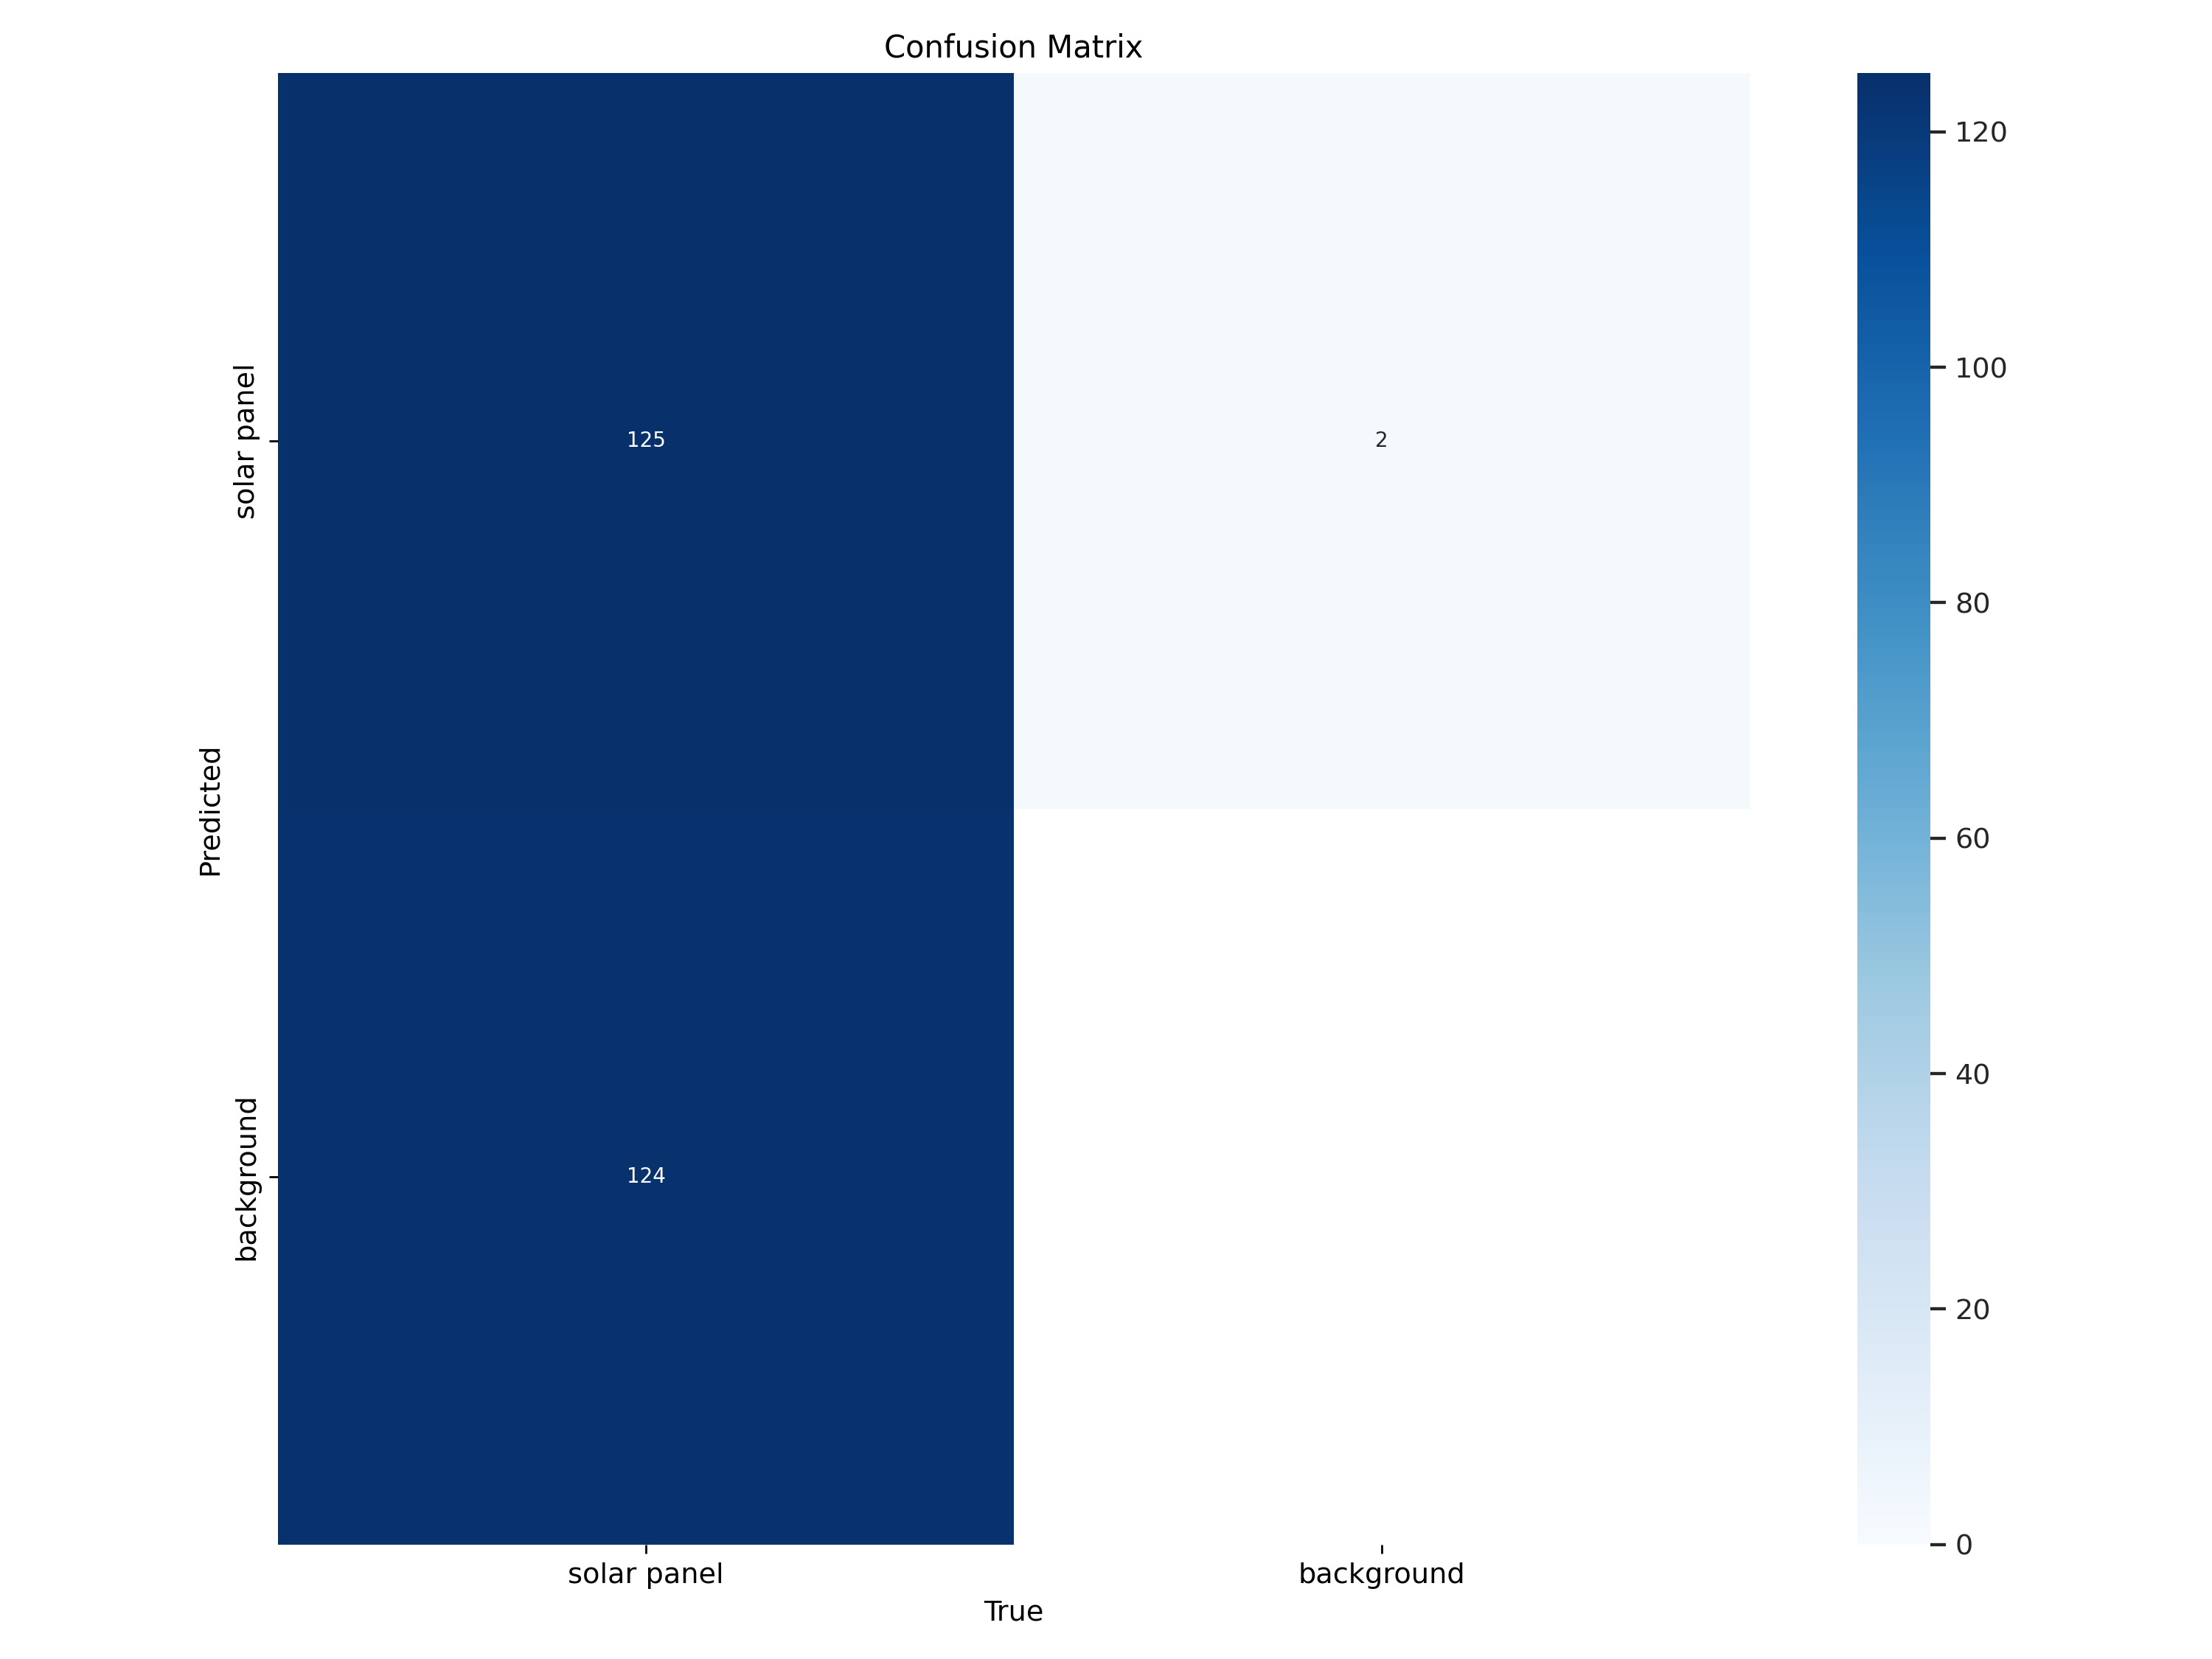

In [7]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train5/confusion_matrix.png', width=600)

/workspaces/solar_eyes/sandbox


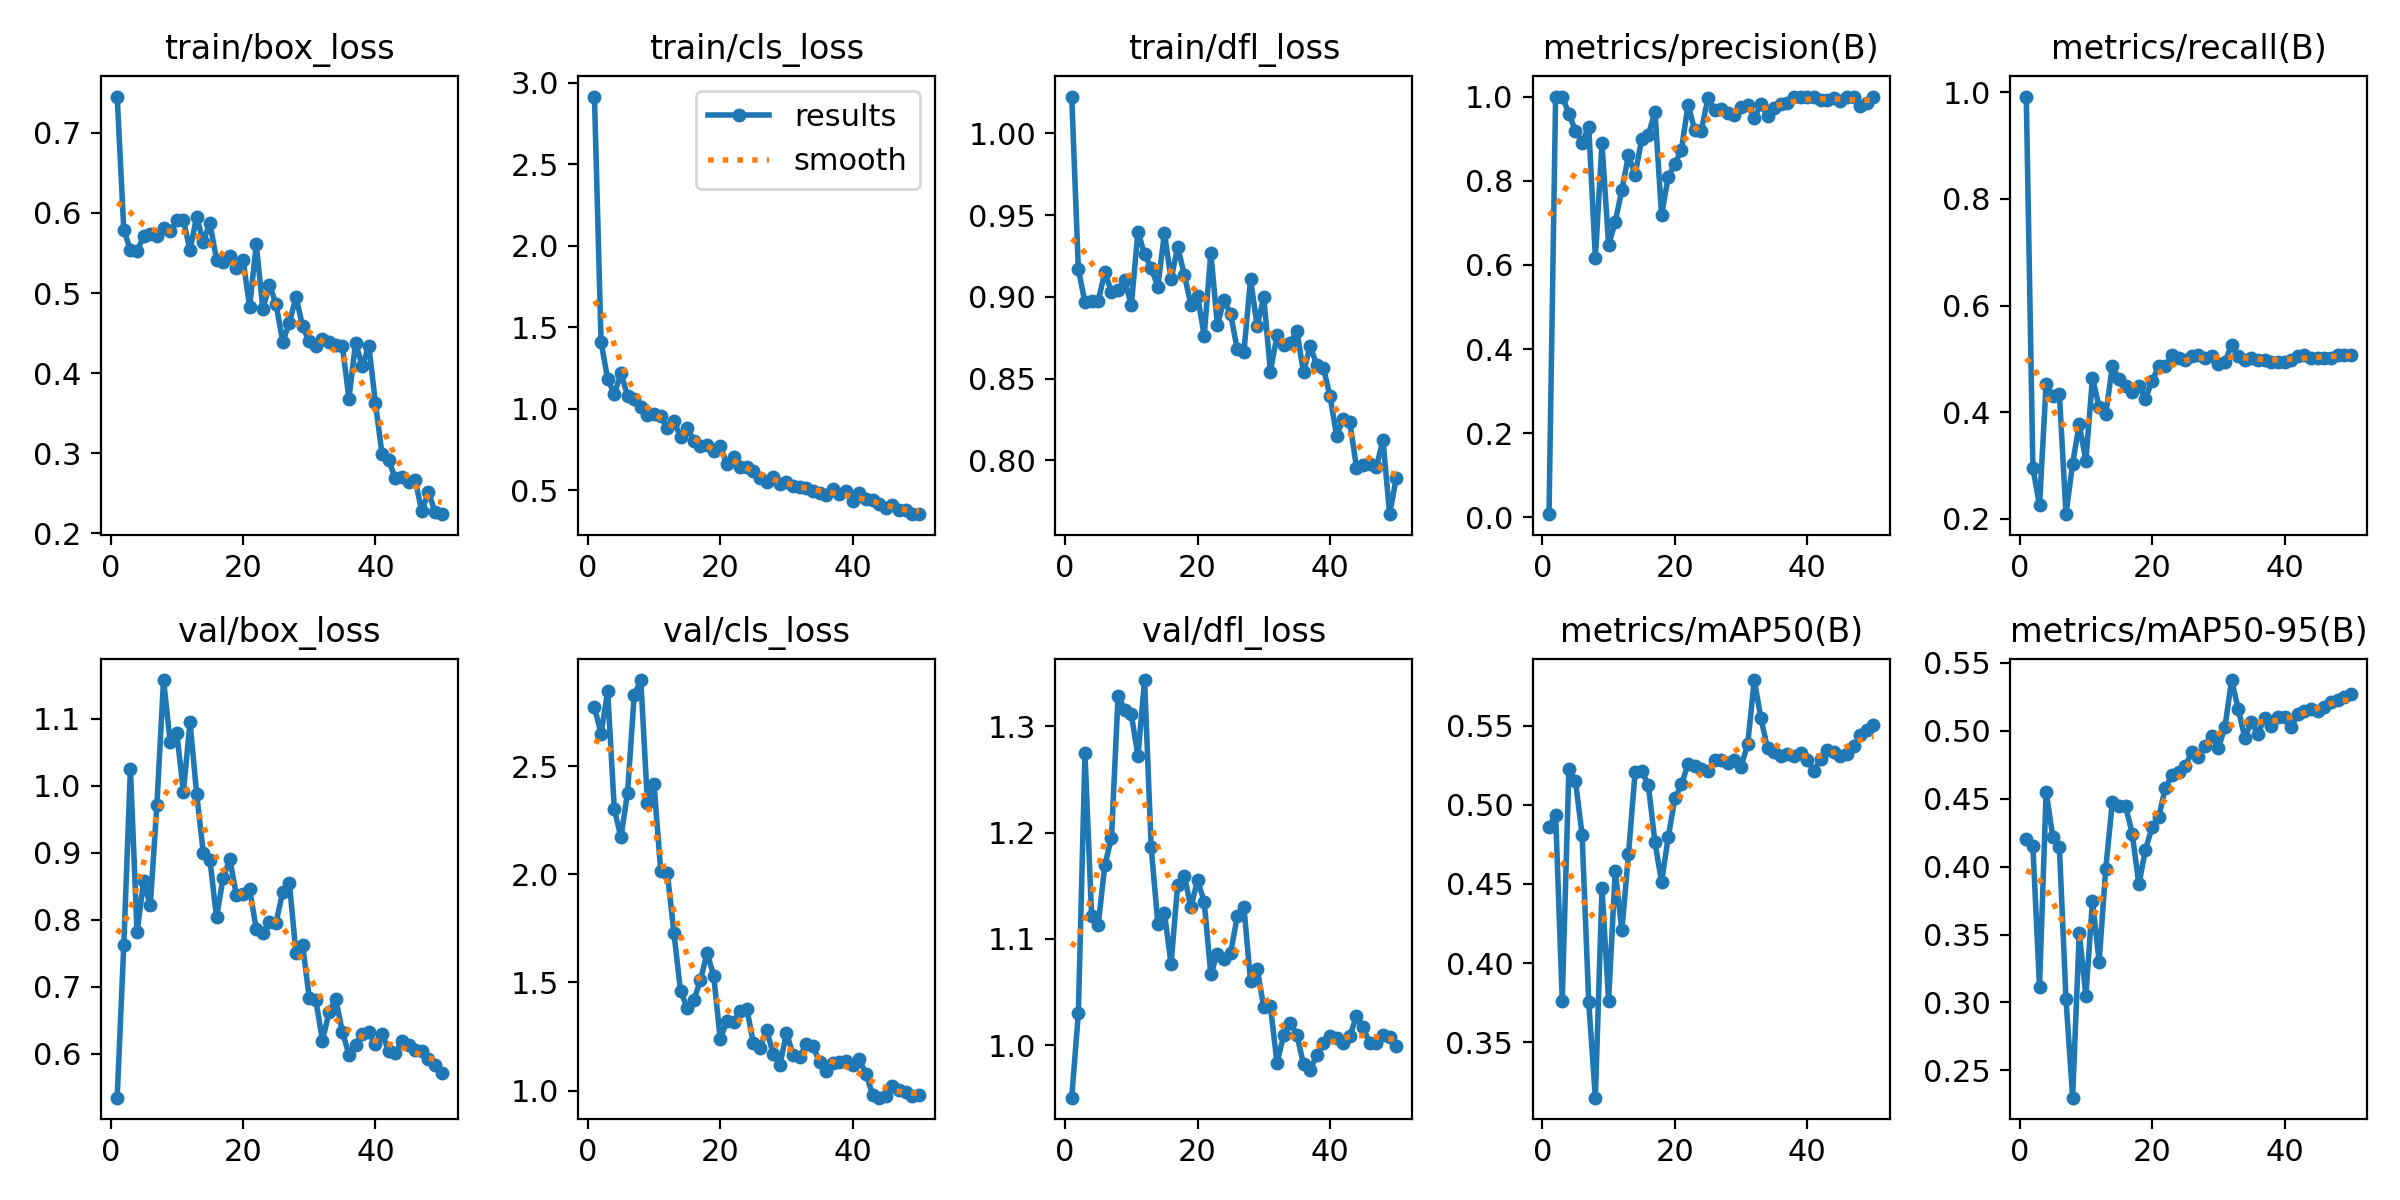

In [8]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train5/results.png', width=600)

/workspaces/solar_eyes/sandbox


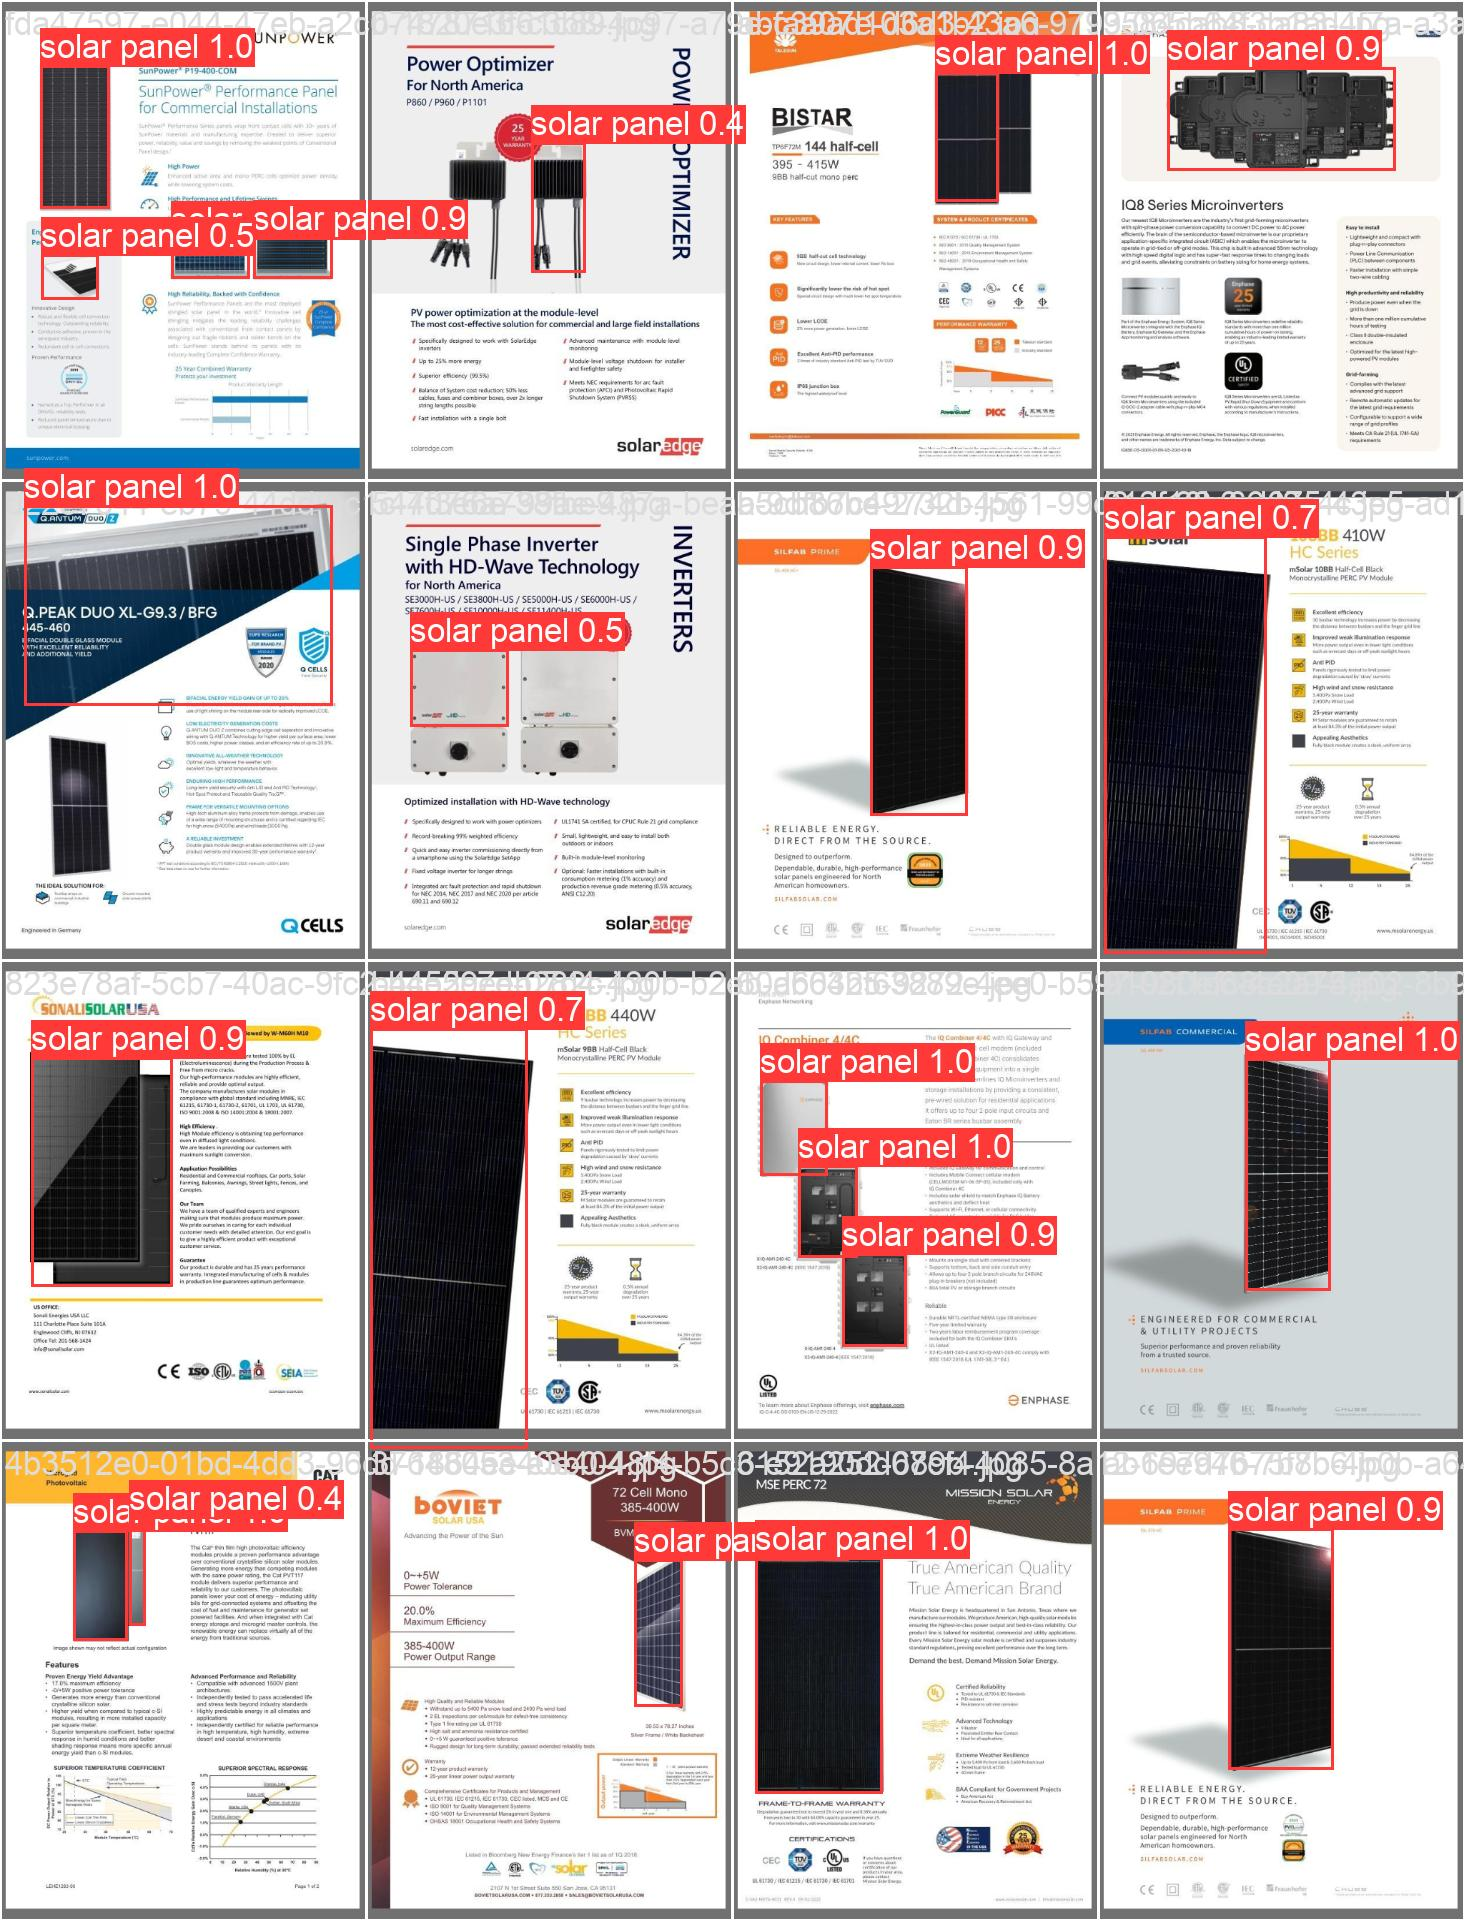

In [9]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train5/val_batch0_pred.jpg', width=600)

## 🎬 Run Inference on a video

In [10]:
INPUT_VIDEO_PATH = TEST_VIDEO_PATHS[0]
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

NameError: name 'TEST_VIDEO_PATHS' is not defined

In [ ]:
!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}